# **Stellar Dataset**

### **Data Description:**
In astronomy, stellar classification is the classification of stars based on their spectral characteristics. The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics.


### **Data Content:**
The data consists of observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar.

### **Data Dictionary:**
- obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- alpha = Right Ascension angle (at J2000 epoch)
- delta = Declination angle (at J2000 epoch)
- u = Ultraviolet filter in the photometric system
- g = Green filter in the photometric system
- r = Red filter in the photometric system
- i = Near Infrared filter in the photometric system
- z = Infrared filter in the photometric system
- run_ID = Run Number used to identify the specific scan
- rereun_ID = Rerun Number to specify how the image was processed
- cam_col = Camera column to identify the scanline within the run
- field_ID = Field number to identify each field
- spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
- class = object class (galaxy, star or quasar object) << your target
- redshift = redshift value based on the increase in wavelength
- plate = plate ID, identifies each plate in SDSS
- MJD = Modified Julian Date, used to indicate when a given piece of SDSS - - - data was taken
- fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [21]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [22]:
df = pd.read_csv("data/stellar.csv")
df.head()

,Unnamed: 0,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,41029,1.237649e+18,194.748212,-0.911226,25.77469,22.72579,20.84263,19.80384,19.29726,756,301,1,527,4.271919e+18,GALAXY,0.525770,3794,55241,926
1,42888,1.237661e+18,140.525977,35.614836,21.94718,21.31617,20.21319,19.45814,19.09832,3560,301,4,221,5.228710e+18,GALAXY,0.439029,4644,55922,111
2,82610,1.237658e+18,125.922894,38.044046,23.47268,21.34390,19.41544,18.67742,18.14655,2822,301,2,135,4.233595e+18,GALAXY,0.414493,3760,55268,770
3,89586,1.237664e+18,18.634831,0.468756,20.03793,18.13051,17.21534,16.80004,16.48915,4263,301,5,240,1.217236e+18,GALAXY,0.091736,1081,52531,503
4,14627,1.237666e+18,52.832458,1.215699,20.72916,20.34843,20.11169,19.75053,19.74247,4849,301,6,807,8.028670e+17,QSO,1.562706,713,52178,365


In [23]:
df.shape

(80000, 19)

In [24]:
df.columns

Index(['Unnamed: 0', 'obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z',
       'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class',
       'redshift', 'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   80000 non-null  int64  
 1   obj_ID       80000 non-null  float64
 2   alpha        80000 non-null  float64
 3   delta        80000 non-null  float64
 4   u            80000 non-null  float64
 5   g            80000 non-null  float64
 6   r            80000 non-null  float64
 7   i            80000 non-null  float64
 8   z            80000 non-null  float64
 9   run_ID       80000 non-null  int64  
 10  rerun_ID     80000 non-null  int64  
 11  cam_col      80000 non-null  int64  
 12  field_ID     80000 non-null  int64  
 13  spec_obj_ID  80000 non-null  float64
 14  class        80000 non-null  object 
 15  redshift     80000 non-null  float64
 16  plate        80000 non-null  int64  
 17  MJD          80000 non-null  int64  
 18  fiber_ID     80000 non-null  int64  
dtypes: f

In [26]:
df.duplicated().sum()

0

In [27]:
df.isnull().sum().sum()

0

In [28]:
df.drop('Unnamed: 0', axis='columns', inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       80000 non-null  float64
 1   alpha        80000 non-null  float64
 2   delta        80000 non-null  float64
 3   u            80000 non-null  float64
 4   g            80000 non-null  float64
 5   r            80000 non-null  float64
 6   i            80000 non-null  float64
 7   z            80000 non-null  float64
 8   run_ID       80000 non-null  int64  
 9   rerun_ID     80000 non-null  int64  
 10  cam_col      80000 non-null  int64  
 11  field_ID     80000 non-null  int64  
 12  spec_obj_ID  80000 non-null  float64
 13  class        80000 non-null  object 
 14  redshift     80000 non-null  float64
 15  plate        80000 non-null  int64  
 16  MJD          80000 non-null  int64  
 17  fiber_ID     80000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usa

In [30]:
df['fiber_ID'] = df['fiber_ID'].astype(str)
df['spec_obj_ID'] = df['spec_obj_ID'].astype(str)
df['field_ID'] = df['field_ID'].astype(str)
df['rerun_ID'] = df['rerun_ID'].astype(str)
df['run_ID'] = df['run_ID'].astype(str)
df['obj_ID'] = df['obj_ID'].astype(str)
df['plate'] = df['plate'].astype(str)


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       80000 non-null  object 
 1   alpha        80000 non-null  float64
 2   delta        80000 non-null  float64
 3   u            80000 non-null  float64
 4   g            80000 non-null  float64
 5   r            80000 non-null  float64
 6   i            80000 non-null  float64
 7   z            80000 non-null  float64
 8   run_ID       80000 non-null  object 
 9   rerun_ID     80000 non-null  object 
 10  cam_col      80000 non-null  int64  
 11  field_ID     80000 non-null  object 
 12  spec_obj_ID  80000 non-null  object 
 13  class        80000 non-null  object 
 14  redshift     80000 non-null  float64
 15  plate        80000 non-null  object 
 16  MJD          80000 non-null  int64  
 17  fiber_ID     80000 non-null  object 
dtypes: float64(8), int64(2), object(8)
memory usag

In [32]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [33]:
df['class'].value_counts()

GALAXY    47556
STAR      17275
QSO       15169
Name: class, dtype: int64

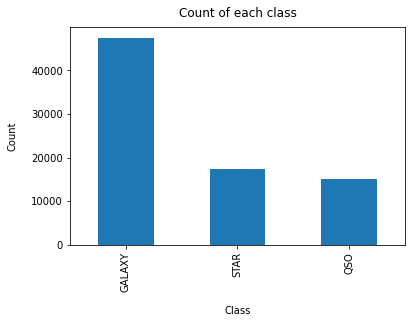

In [35]:
df['class'].value_counts().plot(kind='bar');
plt.xlabel("Class", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of each class", y=1.02);